# Numpy Reader

## Overview

This example shows how to read Numpy array files (*.npy), with DALI's ``readers.numpy`` reader. This notebook also shows how to use DALI to load numpy files directly to GPU memory, thanks to NVIDIA GPUDirect Storage, and how to use the region-of-interest (ROI) API to load regions of the array.

The reader extracts the shape and the data type information directly from the files. Please note that only Numpy v1 (and not v2) files are currently supported. Numpy v1 are the most commonly used. See the [numpy file format specification](https://numpy.org/neps/nep-0001-npy-format.html) for more details.

The operator returns arrays with shapes taken from the files. DALI tensors are always stored in C (row-major) order. If the files contain the data in FORTRAN (column-major) order, the operator will automatically transpose the data to C order. This transposition adds significant time to the loading process. Therefore, we recommend storing files in C order when possible.

## Test data

In this example we are going to work with 3D MRI data, available in the [DALI_extra](https://github.com/NVIDIA/DALI_extra) repository. The environment variable ``DALI_EXTRA_PATH`` should point to the location of DALI_extra. Ensure that you check out the correct release tag that corresponds to the installed version of DALI. 

We will be working with 3D MRI scans in two formats:

1. 2D slices, with one file per slice:

```
npy_2d_slices
└── STU00001
    ├── SER00001
    │   ├── 0.npy
    │   ├── 1.npy
    │   ├── 2.npy
    │   ├── 3.npy
    │   └── 4.npy
```

2. 3D arrays with the whole volume

```
npy_3d
└── STU00001
    ├── SER00001.npy
```

In [1]:
import os

batch_size = 4  # to be used in pipelines
dali_extra_dir = os.environ["DALI_EXTRA_PATH"]
data_dir_2d = os.path.join(
    dali_extra_dir, "db", "3D", "MRI", "Knee", "npy_2d_slices", "STU00001"
)
data_dir_3d = os.path.join(
    dali_extra_dir, "db", "3D", "MRI", "Knee", "npy_3d", "STU00001"
)

Let us introduce a utility function to plot batches of samples:

In [2]:
# misc python stuff
import numpy as np
from glob import glob
import shutil
import tempfile

# visualization
from PIL import Image
import matplotlib.pyplot as plt


def plot_batch(np_arrays, nsamples=None):
    if nsamples is None:
        nsamples = len(np_arrays)
    fig, axvec = plt.subplots(
        nrows=1, ncols=nsamples, figsize=(10, 10 * nsamples)
    )
    for i in range(nsamples):
        ax = axvec[i]
        ax.tick_params(
            left=False, bottom=False, labelleft=False, labelbottom=False
        )
        ax.imshow(Image.fromarray(np_arrays[i]))
    plt.tight_layout()

We can check that the data is equivalent in both representations:

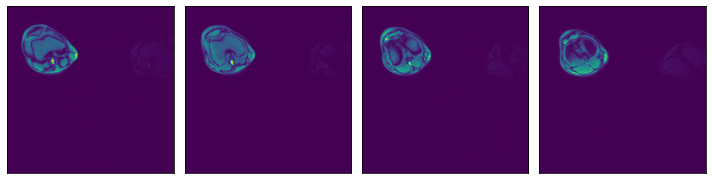

In [3]:
ser00001_2d = [
    np.load(os.path.join(data_dir_2d, "SER00001", f"{i}.npy")) for i in range(4)
]
plot_batch(ser00001_2d)

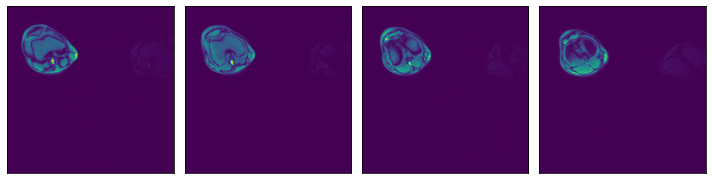

In [4]:
ser00001_3d = np.load(os.path.join(data_dir_3d, "SER00001.npy"))
plot_batch([ser00001_3d[0], ser00001_3d[1], ser00001_3d[2], ser00001_3d[3]])

## Usage

The ``readers.numpy`` reader can be configured in different ways. Let us see some examples.

### Glob filter

Read all files under a specied directory specified by the argument ``file_root``, that match a particular glob string, specified by the ``file_filter`` argument.

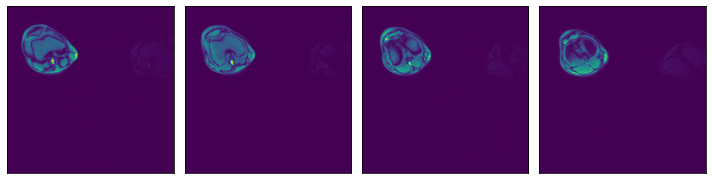

In [5]:
from nvidia.dali import pipeline_def, fn

data_dir = os.path.join(data_dir_2d, "SER00001")


@pipeline_def(batch_size=batch_size, num_threads=3, device_id=0)
def pipe1():
    data = fn.readers.numpy(
        device="cpu", file_root=data_dir, file_filter="*.npy"
    )
    return data


def run(p):
    p.build()  # build the pipeline
    outputs = p.run()  # Run once
    # Getting the batch as a list of numpy arrays, for displaying
    batch = [np.array(outputs[0][s]) for s in range(batch_size)]
    return batch


data1 = run(pipe1())
plot_batch(data1)

### Text file with a list of file paths

Read all files specified by a text file where each line contains a path to a file, relative to the ``file_root`` directory.

In [6]:
# Used to verify that two batches are identical
def assert_all_equal(batch1, batch2):
    assert len(batch1) == len(batch2)
    batch_size = len(batch1)
    for i in range(batch_size):
        np.testing.assert_array_equal(batch1[i], batch2[i])


# Listing all *.npy files in data_dir
files = sorted([f for f in os.listdir(data_dir) if ".npy" in f])


# Defining a pipeline taking the file list file path as an argument
@pipeline_def(batch_size=batch_size, num_threads=3, device_id=0)
def pipe2(file_list_path):
    data = fn.readers.numpy(
        device="cpu", file_root=data_dir, file_list=filelist_path
    )
    return data


# Creating a temporary directory to contain the "file list" file.
with tempfile.TemporaryDirectory() as tmp_dir:
    # Creating a file_list text file, which contains the names of the data files
    # to be loaded
    filelist_path = os.path.join(tmp_dir, "test_file_list.txt")
    with open(filelist_path, "w") as f:
        f.writelines("\n".join(files))

    # Displaying the contents of the file we just created
    print("File list contents:")
    with open(filelist_path, "r") as f:
        print(f.read())
    print("\n")

    data2 = run(pipe2(file_list_path=filelist_path))
    assert_all_equal(data1, data2)

File list contents:
0.npy
1.npy
2.npy
3.npy
4.npy




### List of file paths

Read all files specified by a list of strings containing file paths, relative to the ``file_root`` directory.

In [7]:
# Defining a pipeline taking a list of files directly as a keyword argument
@pipeline_def(batch_size=batch_size, num_threads=3, device_id=0)
def pipe3():
    data = fn.readers.numpy(device="cpu", file_root=data_dir, files=files)
    return data


data3 = run(pipe3())
assert_all_equal(data1, data3)

### Higher dimensionality

Numpy reader can also be used to load data of higher dimensionality (up to 6 dimensions). Let's demonstrate with our 3D MRI arrays

Sample 0 shape: (5, 512, 512)
Sample 1 shape: (9, 512, 512)
Sample 2 shape: (2, 512, 512)
Sample 3 shape: (38, 320, 320)


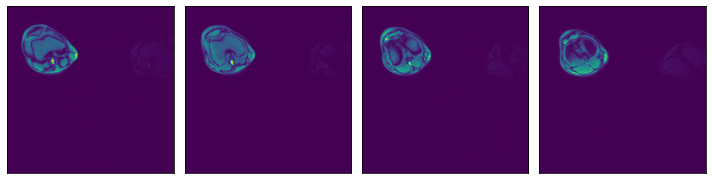

In [8]:
@pipeline_def(batch_size=batch_size, num_threads=3, device_id=0)
def pipe_3d():
    data = fn.readers.numpy(
        device="cpu", file_root=data_dir_3d, file_filter="*.npy"
    )
    return data


data_3d = run(pipe_3d())
for s in range(len(data_3d)):
    print(f"Sample {s} shape: {data_3d[s].shape}")

# Displaying first 4 slices of the first sample in the batch
plot_batch(
    [
        data_3d[0][0, :, :],
        data_3d[0][1, :, :],
        data_3d[0][2, :, :],
        data_3d[0][3, :, :],
    ]
)

## Region-of-interest (ROI) API

In the example shown above, we see that the relevant data is concentrated in the upper left quadrant of the image and the rest does not contain useful information. This is not true for all the images in the dataset, but it will serve us as a good example to demonstrate ROI reading.

Numpy reader allows the user to specify a region of interest, equivalent to the arguments specified to ``slice`` operation. The benefit is that the reader will only read the relevant part of the file, saving I/O bandwidth and memory utilization. Note that setting the ``dont_use_mmap`` argument to False will negate that performance benefit, with the entire file being read first and then sliced.

The ROI can be specified in absolute or relative terms, and can be specified on a subset of the array's axes. For dimensions not specified in the ROI, the whole extent of the array shall be used. For full documentation on ROI decoding, refer to [readers.numpy documentation](../../../operations/nvidia.dali.fn.readers.numpy.html) (see arguments ``roi_start``, ``rel_roi_start``, ``roi_end``, ``rel_roi_end``, ``roi_shape``, ``rel_roi_shape``, ``axes``).

Let us see a few practical examples:

### ROI start and end, in absolute coordinates

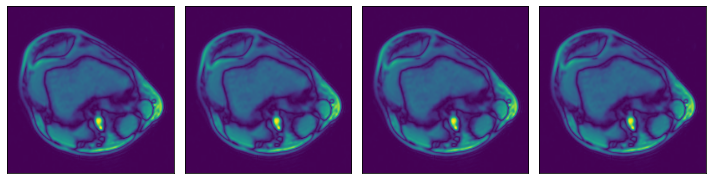

In [9]:
# One file is enough for this example
files = ["0.npy"]


@pipeline_def(batch_size=batch_size, num_threads=3, device_id=0)
def pipe_roi1():
    data = fn.readers.numpy(
        device="cpu",
        file_root=data_dir,
        files=files,
        roi_start=[30, 30],
        roi_end=[230, 230],
    )
    return data


data_roi1 = run(pipe_roi1())
plot_batch(data_roi1)

### ROI start and end, in relative coordinates

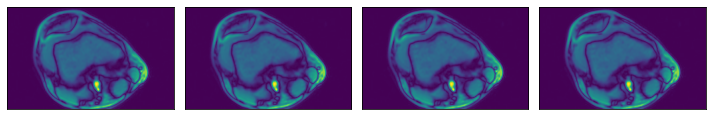

In [10]:
@pipeline_def(batch_size=batch_size, num_threads=3, device_id=0)
def pipe_roi2():
    data = fn.readers.numpy(
        device="cpu",
        file_root=data_dir,
        files=files,
        rel_roi_start=[0.1, 0.01],
        rel_roi_end=[0.4, 0.5],
    )
    return data


data_roi2 = run(pipe_roi2())
plot_batch(data_roi2)

### Specifying a subset of the array's axes


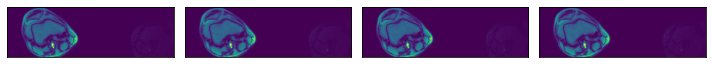

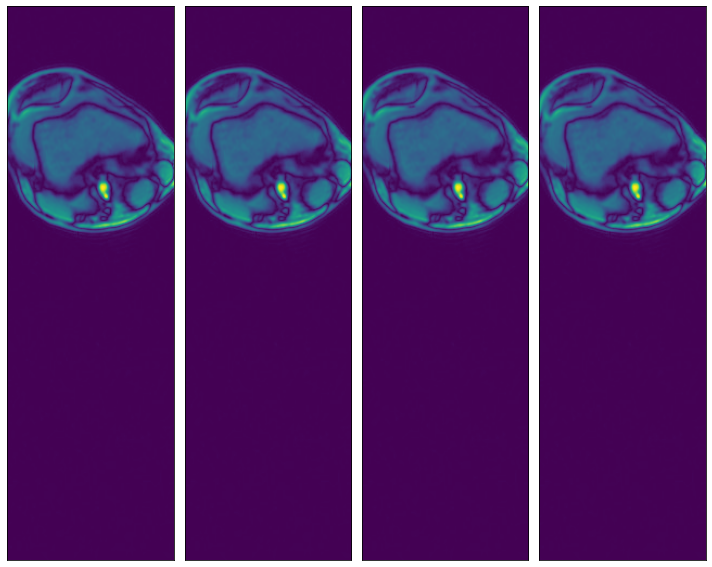

In [11]:
@pipeline_def(batch_size=batch_size, num_threads=3, device_id=0)
def pipe_roi3(rel_roi_start, rel_roi_end, roi_axes):
    data = fn.readers.numpy(
        device="cpu",
        file_root=data_dir,
        files=files,
        rel_roi_start=rel_roi_start,
        rel_roi_end=rel_roi_end,
        roi_axes=roi_axes,
    )
    return data


p1 = pipe_roi3(rel_roi_start=[0.1], rel_roi_end=[0.4], roi_axes=(0,))
data_roi3_1 = run(p1)
plot_batch(data_roi3_1)

p2 = pipe_roi3(rel_roi_start=[0.1], rel_roi_end=[0.4], roi_axes=(1,))
data_roi3_2 = run(p2)
plot_batch(data_roi3_2)

### Out of bounds access

Additionally, the user can choose what happens when a ROI falls outside of the bounds of the array. By default, out-of-bounds access results in an error, but it can be controlled by the ``out_of_bounds_policy`` argument.

Let us see an example of a pipeline configured to pad with zeros when the ROI falls out of bounds:

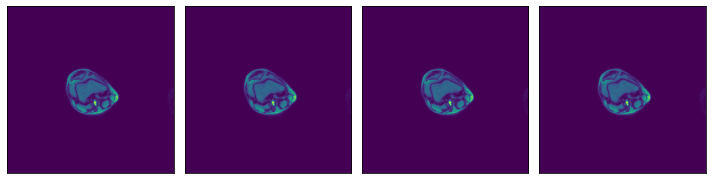

In [12]:
@pipeline_def(batch_size=batch_size, num_threads=3, device_id=0)
def pipe_roi_oob():
    data = fn.readers.numpy(
        device="cpu",
        file_root=data_dir,
        files=files,
        roi_start=(-150, -150),
        roi_end=(400, 400),
        out_of_bounds_policy="pad",
        fill_value=0,
        shard_id=0,
        num_shards=1,
    )
    return data


data_oob = run(pipe_roi_oob())
plot_batch(data_oob)

## GPUDirect Storage Support

DALI Numpy Reader supports [GPUDirect Storage (GDS)](https://developer.nvidia.com/gpudirect-storage) via libcufile. GDS enables a direct data path between storage and GPU memory and avoids extra copies through a bounce buffer in the CPU’s memory.

In order to enable GDS support in DALI, make sure GDS is installed. On Systems with CUDA 11.4 or newer, GDS is already installed as part of the CUDA 11.4 SDK. For older CUDA releases, please install GDS separately (follow the link above for instructions).

Once GDS is installed, it can be used by simply switching the device of the reader to ``"gpu"``. Note that if GDS is not available, you will likely see a CUDA Driver API error when trying to execute the pipeline.

(4, 512, 512)


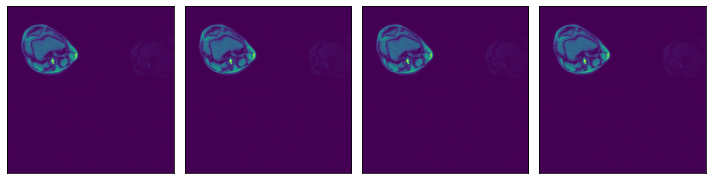

In [13]:
@pipeline_def(batch_size=batch_size, num_threads=3, device_id=0)
def pipe_gds():
    data = fn.readers.numpy(device="gpu", file_root=data_dir, files=files)
    return data


p = pipe_gds()
p.build()
pipe_out = p.run()

# as_cpu() to copy the data back to CPU memory
data_gds = pipe_out[0].as_cpu().as_array()
print(data_gds.shape)
plot_batch(data_gds)